In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

### get data ready
 - read data
 - format the columns and column names 
 - add language detection
 - filter by agreement and language

 - language detection takes long time, on the full SDG dataset, it takes neara 3 minutes
 - may not want to run it unless really needed, or run it after filtering by other dimensions

In [3]:
text_df = pd.read_csv("/Users/yingli/Downloads/osdg-community-data-v2023-01-01.csv", sep = "\t", quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
#text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
#text_df = text_df.query("lang == 'en'") # language detection cost extra time, do it after other filterings to minimize cost
text_df.reset_index(inplace=True)

### looking at language models and feature for the task of document classification
 - split the data into train and test
 - construct text feature vectors using 
  - CountVectorizer, TfidfVectorizer
  - with unigram, bigram, and unigram and bigram combined
 - use Naive Bayes - multinomialNB implementation to assess the feature vectors' effectiveness
 - inspect the top informative features (tokens)

In [4]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

### using count vectors on multinomialNB

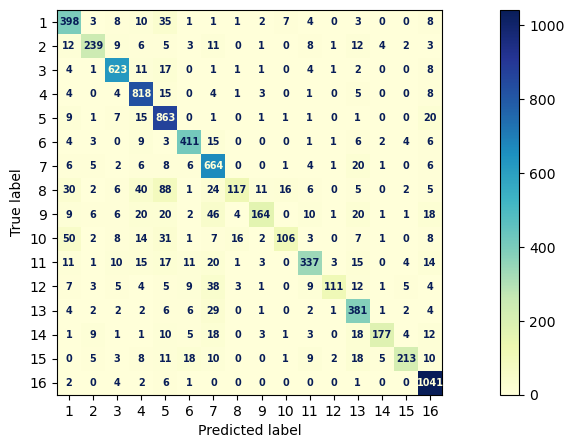

In [72]:
X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train) 
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"])


 - understanding metrics in the context of multiple classes

In [73]:
# manually check precision for sdg 1
tp = 398
fp = 153 #(summing vertically below 398)
fn = 83 #(summing horizentally to the right of 398)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) /(precision + recall)

In [74]:
print('precision for SDG 1: {:.4}'.format(precision))
print('recall for SDG 1: {:.4}'.format(recall))
print('f1 for SDG 1: {:.4}'.format(f1))

precision for SDG 1: 0.7223
recall for SDG 1: 0.8274
f1 for SDG 1: 0.7713


 - inspecting (and comparing) performance through classification_report

In [75]:
print(metrics.classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           1     0.7223    0.8274    0.7713       481
           2     0.8475    0.7563    0.7993       316
           3     0.8926    0.9243    0.9082       674
           4     0.8338    0.9479    0.8872       863
           5     0.7570    0.9380    0.8379       920
           6     0.8653    0.8839    0.8745       465
           7     0.7469    0.9096    0.8203       730
           8     0.8125    0.3314    0.4708       353
           9     0.8497    0.5000    0.6296       328
          10     0.7970    0.4141    0.5450       256
          11     0.8383    0.7294    0.7801       462
          12     0.9098    0.5115    0.6549       217
          13     0.7243    0.8600    0.7864       443
          14     0.9171    0.6730    0.7763       263
          15     0.8987    0.6805    0.7745       313
          16     0.8860    0.9849    0.9328      1057

    accuracy                         0.8184      8141
   macro avg     0.8312   

 - inspect individual scores

In [76]:
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

accuracy = 0.8184
macro-averaged precision = 0.8312
micro-averaged precision = 0.8184
macro-averaged recall = 0.742
micro-averaged recall = 0.8184


 - put it all together
 - unigram and bigram together

              precision    recall  f1-score   support

           1       0.77      0.72      0.74       481
           2       0.91      0.66      0.77       316
           3       0.93      0.90      0.92       674
           4       0.83      0.96      0.89       863
           5       0.60      0.93      0.73       920
           6       0.87      0.85      0.86       465
           7       0.62      0.96      0.76       730
           8       0.87      0.08      0.14       353
           9       0.92      0.26      0.41       328
          10       0.91      0.16      0.27       256
          11       0.88      0.69      0.77       462
          12       0.95      0.25      0.39       217
          13       0.82      0.81      0.82       443
          14       0.95      0.53      0.68       263
          15       0.95      0.58      0.72       313
          16       0.72      0.99      0.84      1057

    accuracy                           0.76      8141
   macro avg       0.84   

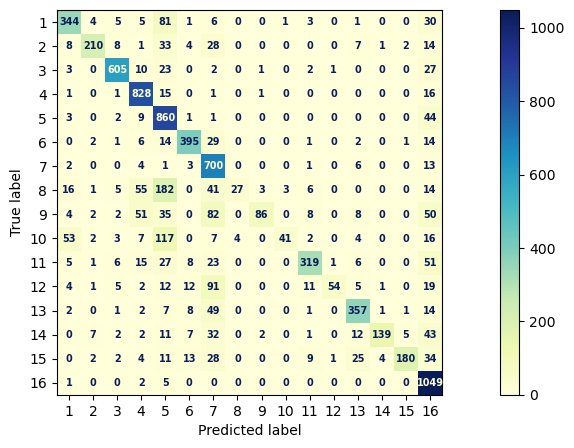

In [77]:
X_train_count_vectorizer = CountVectorizer(ngram_range=(1,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train)  
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"])
print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))


### from the above, it looks like using only bigram performed better than using both unigram and bigram

 - using tfidf vector on multinomialNB

              precision    recall  f1-score   support

           1       0.89      0.51      0.65       481
           2       0.98      0.19      0.31       316
           3       0.96      0.81      0.88       674
           4       0.69      0.96      0.80       863
           5       0.44      0.94      0.60       920
           6       0.90      0.67      0.77       465
           7       0.56      0.95      0.70       730
           8       1.00      0.00      0.01       353
           9       1.00      0.03      0.06       328
          10       0.75      0.01      0.02       256
          11       0.94      0.39      0.55       462
          12       1.00      0.05      0.10       217
          13       0.93      0.60      0.73       443
          14       1.00      0.19      0.32       263
          15       0.96      0.25      0.39       313
          16       0.56      0.99      0.72      1057

    accuracy                           0.64      8141
   macro avg       0.85   

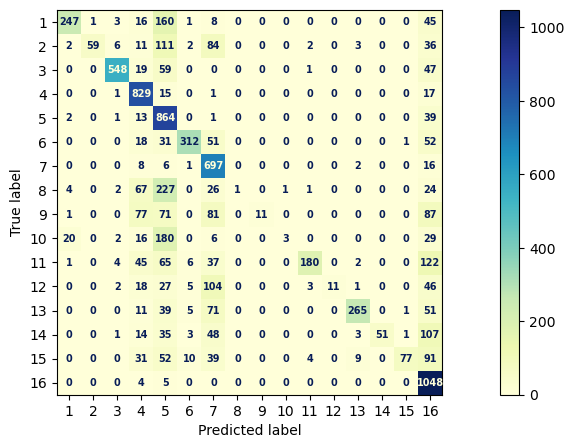

In [12]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

tfidf_multinomial_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomial_clf.predict(X_test_tfidf_vector)

print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax,cmap=mpl.colormaps["YlGnBu"])


### using multinomialNB on tfidf vectors seems to perform even worse
 - let's run one more using tfidf but with bigram only

              precision    recall  f1-score   support

           1       0.90      0.52      0.66       481
           2       0.97      0.11      0.20       316
           3       0.93      0.77      0.84       674
           4       0.65      0.95      0.77       863
           5       0.46      0.94      0.61       920
           6       0.95      0.57      0.71       465
           7       0.73      0.88      0.80       730
           8       1.00      0.01      0.02       353
           9       1.00      0.02      0.03       328
          10       0.86      0.02      0.05       256
          11       0.94      0.30      0.45       462
          12       1.00      0.03      0.06       217
          13       0.92      0.57      0.71       443
          14       1.00      0.05      0.10       263
          15       0.97      0.11      0.20       313
          16       0.42      0.99      0.59      1057

    accuracy                           0.60      8141
   macro avg       0.86   

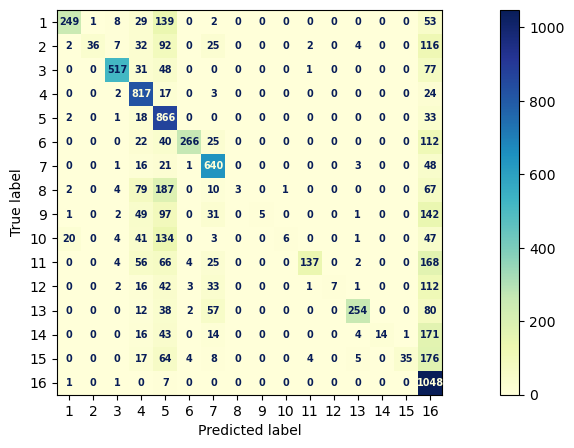

In [21]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

tfidf_multinomial_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomial_clf.predict(X_test_tfidf_vector)

print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax,cmap=mpl.colormaps["YlGnBu"])


### multinomialNB on ifidf vector formed worse still if we use only bigram
 - performace order of worsening in order
  - multinomialNB on count vectors of bigram only
  - multinomialNB on count vectors of unigram and bigram
  - multinomialNB on tfidf vectors of unigram and bigram
  - multinomialNB on tfidf vectors of bigram only

### looking at the most informative features

In [78]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
labels = X_train_tfidf_vectorizer.get_feature_names_out()

X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_multinomial_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomial_clf.predict(X_test_tfidf_vector)

In [79]:
most_informative_feature_for_class(X_train_tfidf_vectorizer,tfidf_multinomial_clf, [0, 1], n = 20)

SDG 0 : child poverty                   -10.6351
SDG 0 : poverty rate                    -10.9477
SDG 0 : poverty line                    -10.9615
SDG 0 : poverty rates                   -11.0577
SDG 0 : extreme poverty                 -11.085
SDG 0 : social protection               -11.1268
SDG 0 : poverty reduction               -11.1782
SDG 0 : monetary poverty                -11.4349
SDG 0 : percentage points               -11.5211
SDG 0 : multidimensional poverty        -11.5521
SDG 0 : income distribution             -11.6748
SDG 0 : poverty lines                   -11.7188
SDG 0 : rural areas                     -11.7216
SDG 0 : low income                      -11.7662
SDG 0 : world bank                      -11.7919
SDG 0 : poor children                   -11.8126
SDG 0 : income poverty                  -11.8192
SDG 0 : poor households                 -11.8208
SDG 0 : et al                           -11.8506
SDG 0 : household income                -11.8676

SDG 1 : food securit

### observation on computation cost
 - when doing
    X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
    X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)
 - vs. doing

    X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train).toaray()\
    X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test).toarray()
 - adding .toarray() make the model fitting and prediction much slower
 - the former (without toarray()) is about 10 second, on (2, 2) tfidf
 - the later is about 5 minutes

In [59]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid, feat, coef))
        print("")

In [60]:
most_informative_feature_for_class(X_train_tfidf_vectorizer,tfidf_multinomial_clf, [0, 1], n = 20)

SDG 0 : child poverty                   -10.6351
SDG 0 : poverty rate                    -10.9477
SDG 0 : poverty line                    -10.9615
SDG 0 : poverty rates                   -11.0577
SDG 0 : extreme poverty                 -11.085
SDG 0 : social protection               -11.1268
SDG 0 : poverty reduction               -11.1782
SDG 0 : monetary poverty                -11.4349
SDG 0 : percentage points               -11.5211
SDG 0 : multidimensional poverty        -11.5521
SDG 0 : income distribution             -11.6748
SDG 0 : poverty lines                   -11.7188
SDG 0 : rural areas                     -11.7216
SDG 0 : low income                      -11.7662
SDG 0 : world bank                      -11.7919
SDG 0 : poor children                   -11.8126
SDG 0 : income poverty                  -11.8192
SDG 0 : poor households                 -11.8208
SDG 0 : et al                           -11.8506
SDG 0 : household income                -11.8676

SDG 1 : food securit

In [80]:
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))

In [81]:
print_top_n_features(X_train_tfidf_vectorizer,tfidf_multinomial_clf,[0,1,2,3,4,5,6,7,8,9,10],n=20)

0: child poverty || poverty rate || poverty line || poverty rates || extreme poverty || social protection || poverty reduction || monetary poverty || percentage points || multidimensional poverty || income distribution || poverty lines || rural areas || low income || world bank || poor children || income poverty || poor households || et al || household income
1: food security || food insecurity || agricultural production || developing countries || price volatility || agricultural sector || food production || agro food || food prices || agricultural productivity || climate change || food agriculture || agricultural products || world food || agricultural research || world bank || agricultural policies || food availability || et al || food safety
2: health care || primary care || mental health || health services || life expectancy || public health || oecd countries || et al || care services || health insurance || quality care || ministry health || long term || hiv aids || health spending 

 - MLPClassifier takes very long if we we take beyond unigram
 - it was taking more than 3 hours on my mac and still not finishing
 - if set min_df = 2 or above, it would complete the run
 - or we can run on fewer SDGs

 - use full SDG, min_df = 5: returns within seconds
  - min_df = 4 took 8 minutes

In [92]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words = "english", min_df=4)
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_mlp_clf = MLPClassifier(random_state=1, max_iter=100).fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_mlp_clf.predict(X_test_tfidf_vector)
tfidf_mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.82      0.83      0.83       481
           2       0.85      0.89      0.87       316
           3       0.95      0.95      0.95       674
           4       0.92      0.96      0.94       863
           5       0.92      0.94      0.93       920
           6       0.91      0.92      0.92       465
           7       0.89      0.92      0.90       730
           8       0.71      0.61      0.66       353
           9       0.82      0.84      0.83       328
          10       0.69      0.60      0.64       256
          11       0.86      0.88      0.87       462
          12       0.85      0.78      0.82       217
          13       0.89      0.88      0.89       443
          14       0.93      0.92      0.93       263
          15       0.92      0.87      0.89       313
          16       0.96      0.98      0.97      1057

    accuracy                           0.89      8141
   macro avg       0.87   

In [93]:
tfidf_mlp_clf.n_features_in_

35061

In [86]:
select_sdg = [2,3,4,8,9,10,14,15,16]
docs = text_df.query("sdg in @select_sdg").text
categories = text_df.query("sdg in @select_sdg").sdg
X_train, X_test, y_train, y_test = train_test_split(
    docs, categories, test_size=0.33, random_state=7)

X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

 -  max_iter of 100, 200, 300, did not seem to make a difference in speed nor accuracy

 - this below took 89min 35.6 sec to finish.

<Axes: >

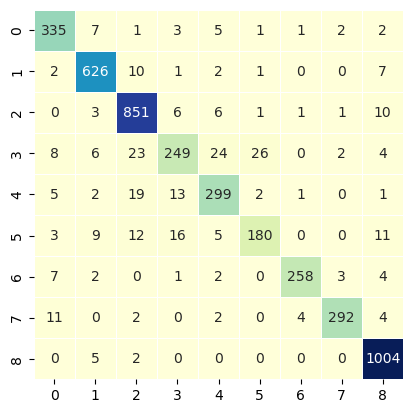

In [88]:
sns.heatmap(
        confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = False,
        fmt = 'd', linewidths = .5, cmap = 'YlGnBu',
    )

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(random_state=1, max_iter=100).fit(X_train_tfidf_vector, y_train)
y_pred = mlp_clf.predict(X_test_tfidf_vector)
mlp_clf.score(X_test_tfidf_vector, y_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.94      0.93      0.94       492
           2       0.96      0.92      0.94       353
           3       0.96      0.98      0.97       638

    accuracy                           0.95      1483
   macro avg       0.95      0.95      0.95      1483
weighted avg       0.95      0.95      0.95      1483



<Axes: >

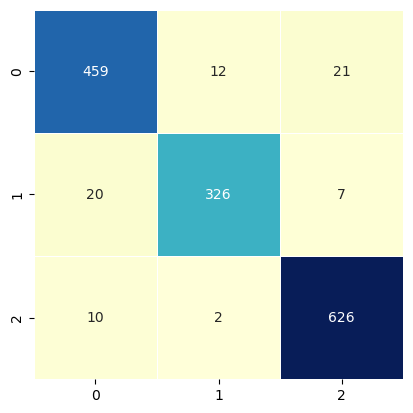

In [ ]:
sns.heatmap(
        confusion_matrix(y_test, y_pred), annot = True, square = True, cbar = False,
        fmt = 'd', linewidths = .5, cmap = 'YlGnBu',
    )

<Axes: >

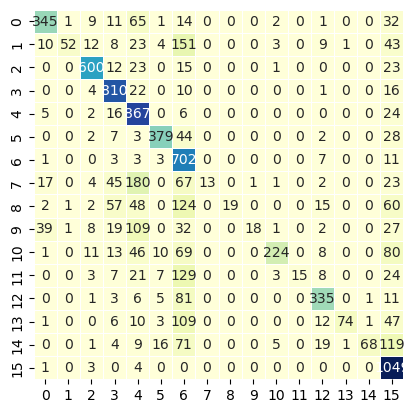

In [ ]:
sns.heatmap(
        confusion_matrix(y_test, predicted), annot = True, square = True, cbar = False,
        fmt = 'd', linewidths = .5, cmap = 'YlGnBu',
    )

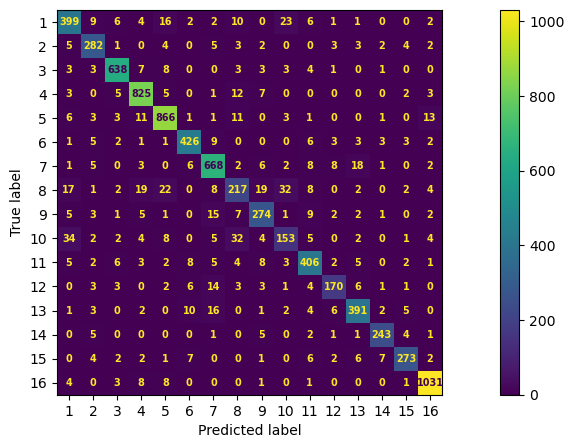

In [94]:
fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax)

 - RidgeClassifier seems to be giving best results compared with MultinomialNB, and NN

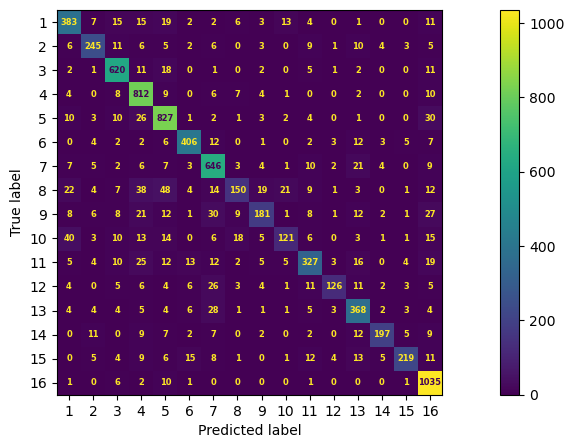

In [ ]:
from sklearn.linear_model import RidgeClassifier

ridge_clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
ridge_clf = ridge_clf.fit(X_train_tfidf_vector, y_train)
y_pred = ridge_clf.predict(X_test_tfidf_vector)
fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax)

In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.77      0.80      0.78       481
           2       0.81      0.78      0.79       316
           3       0.86      0.92      0.89       674
           4       0.81      0.94      0.87       863
           5       0.82      0.90      0.86       920
           6       0.88      0.87      0.88       465
           7       0.80      0.88      0.84       730
           8       0.75      0.42      0.54       353
           9       0.76      0.55      0.64       328
          10       0.72      0.47      0.57       256
          11       0.79      0.71      0.75       462
          12       0.87      0.58      0.70       217
          13       0.76      0.83      0.79       443
          14       0.90      0.75      0.82       263
          15       0.89      0.70      0.78       313
          16       0.85      0.98      0.91      1057

    accuracy                           0.82      8141
   macro avg       0.81   

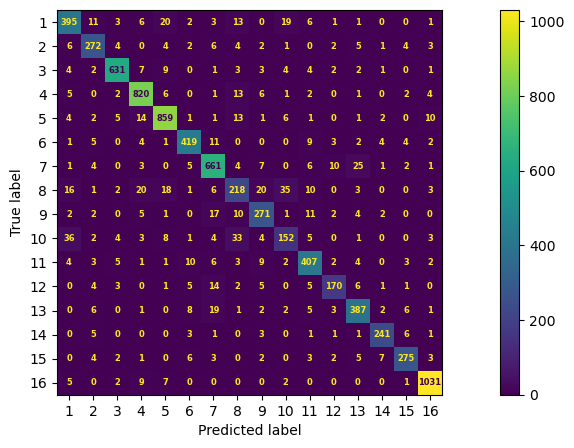

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax)